# Kidney data integration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [ ]:
proj_name = "kidney_integration"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
data_dir = "../data/kidney_integration/"
data_dir = Path(data_dir)

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cuda:3


'Dec05-1038'

In [4]:
folders_samples = {
    "GSE129798": '../data/McMahon_kidney/GSE129798/ransick_adata_processed_Dec04-1820.h5ad',
    "GSE149134": '../data/McMahon_kidney/GSE149134/adata_processed_Dec05-0854.h5ad',
    "GSE151302": '../data/McMahon_kidney/GSE151302/adata_processed_Dec05-0924.h5ad',
    "GSE232479": '../data/McMahon_kidney/GSE232479/kim_adata_processed_Dec05-0802.h5ad',
    "GSE232481": '../data/McMahon_kidney/GSE232481/kim_adata_processed_Dec05-0731.h5ad',
}
sample_species = {
    "GSE129798": 'mouse',
    "GSE149134": 'mouse',
    "GSE151302": 'human',
    "GSE232479": 'human',
    "GSE232481": 'mouse',
}
# Load the data
adata_dict = {}

for key, value in folders_samples.items():
    adata = sc.read(value)
    adata.obs['species'] = sample_species[key]
    adata.obs['dataset'] = key
    print(key, adata.shape)
    adata_dict[key] = adata

GSE129798 (31265, 19125)
GSE149134 (28189, 20672)
GSE151302 (26953, 33538)
GSE232479 (59832, 36601)
GSE232481 (72017, 31053)


In [8]:

human_keys = [key for key, value in sample_species.items() if value == 'human']
mouse_keys = [key for key, value in sample_species.items() if value == 'mouse']

In [20]:
adata_dict['GSE151302'].obs['stage'] = np.NaN

In [22]:
# Integrate human dataset according to sample_species
human_adata_list = [adata_dict[key] for key in human_keys]
human_adata = sc.concat(human_adata_list, join='inner')

In [23]:
human_adata.shape

(86785, 31915)

In [24]:
human_adata.obs

,sample,species,dataset,S_score,G2M_score,phase,stage
AAACCTGAGACCGGAT-1-GSM4572195,GSM4572195,human,GSE151302,-0.014406,-0.010194,G1,NaN
AAACCTGAGAGGTTGC-1-GSM4572195,GSM4572195,human,GSE151302,-0.007966,-0.029097,G1,NaN
AAACCTGAGTCGATAA-1-GSM4572195,GSM4572195,human,GSE151302,-0.005177,-0.015822,G1,NaN
AAACCTGCACGGACAA-1-GSM4572195,GSM4572195,human,GSE151302,0.025456,-0.016542,S,NaN
AAACCTGCAGACAAGC-1-GSM4572195,GSM4572195,human,GSE151302,-0.015964,0.010067,G2M,NaN
...,...,...,...,...,...,...,...
TTTGTTGAGGTAAACT-1-F3,F3,human,GSE232479,-0.080292,-0.041056,G1,15.6Wk
TTTGTTGCAGCTTCGG-1-F3,F3,human,GSE232479,0.107078,-0.006365,S,15.6Wk
TTTGTTGGTACGTAGG-1-F3,F3,human,GSE232479,-0.089688,-0.012660,G1,15.6Wk
TTTGTTGTCAAAGCCT-1-F3,F3,human,GSE232479,-0.102142,0.016910,G2M,15.6Wk


In [28]:
# Run Concord
file_suffix = f"human_{time.strftime('%b%d-%H%M')}"
output_key = f'Concord_{file_suffix}'
feature_list = ccd.ul.select_features(human_adata, n_top_features=10000, flavor='seurat_v3')
cur_ccd = ccd.Concord(adata=human_adata, input_feature=feature_list, 
                      domain_key='sample', 
                      latent_dim=100,
                      n_epochs=10,
                      augmentation_mask_prob = 0.5, 
                      clr_temperature = .5, # Check out advanced usage to learn what this parameter controls, 
                      use_decoder=True,
                      seed=seed, 
                      inplace=False, 
                      verbose=False, 
                      device=device,
                      save_dir=save_dir) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
cur_ccd.encode_adata(input_layer_key='X_log1p', output_key=output_key)

# Save the latent embedding to a filem, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")
human_adata.obsm = cur_ccd.adata.obsm # If not inplace

p_intra_knn: 0.3


Epoch 0 Training: 1348it [00:22, 59.84it/s, loss=3.52]
Epoch 9 Training: 100%|██████████| 1348/1348 [00:23<00:00, 56.87it/s, loss=3.39]


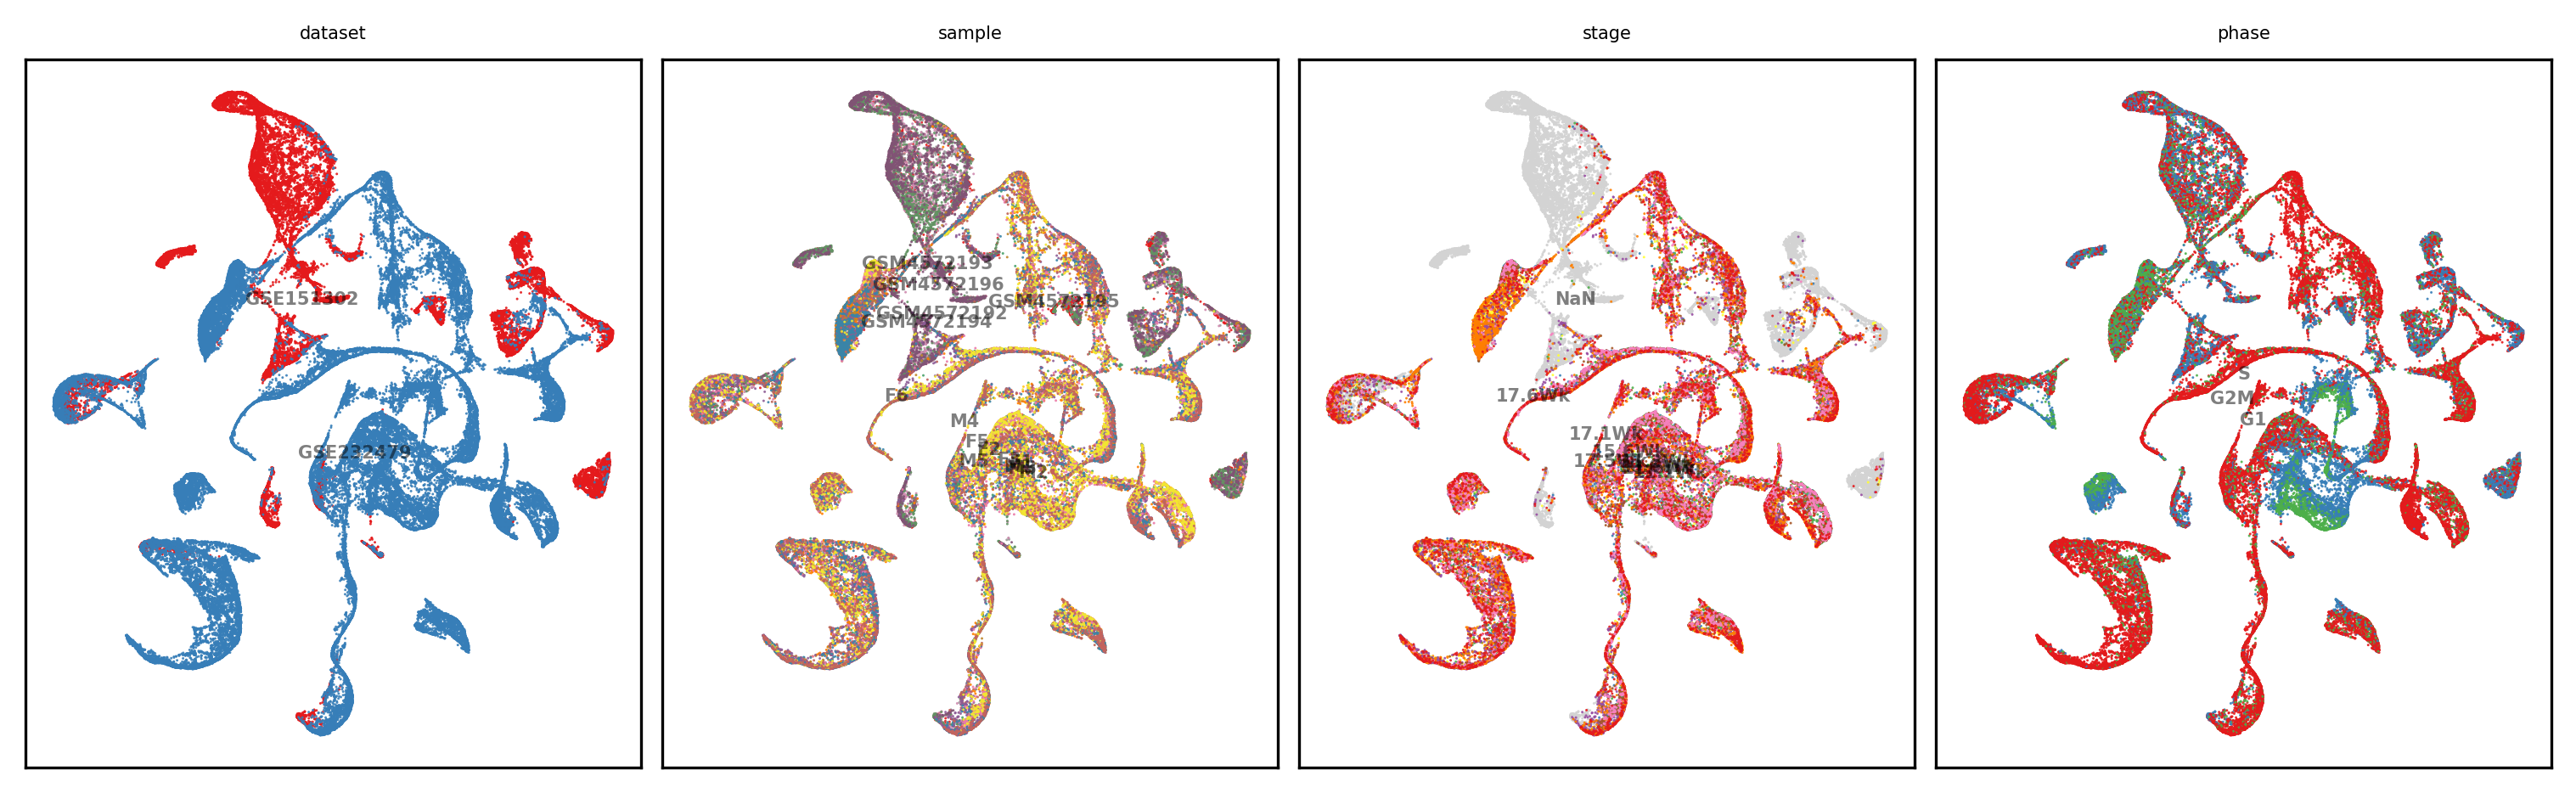

In [29]:
ccd.ul.run_umap(human_adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['dataset', 'sample', 'stage', 'phase']
ccd.pl.plot_embedding(
    human_adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=4, font_size=5, point_size=2, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [ ]:
ccd.ul.run_umap(human_adata, source_key=output_key, result_key=f'{output_key}_UMAP_3D', n_components=3, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
for col in show_cols:
    show_basis = f'{output_key}_UMAP_3D'
    ccd.pl.plot_embedding_3d(
            human_adata, basis=show_basis, color_by=col,
            save_path=save_dir / f'{show_basis}_{col}_{file_suffix}.html',
            point_size=1, opacity=0.8, width=1500, height=1000
        )

In [ ]:
data_dir = "../data/kidney_integration/"
data_dir = Path(data_dir)

In [ ]:

human_adata.write_h5ad(data_dir / f"human_adata_processed_{file_suffix}.h5ad")

file_suffix